<a href="https://colab.research.google.com/github/caiobaptistaa/Econometria-4_PUC-Rio/blob/main/Trabalho_2_Final_Models_Comparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
pd.pandas.set_option('display.max_columns', None)
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from tabulate import tabulate
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')
pred_ar = pd.read_csv('/content/drive/MyDrive/Trabalho-1/pred_ar.csv', sep= ",", low_memory= False)
pred_pc_ar = pd.read_csv('/content/drive/MyDrive/Trabalho-1/pred_pc_ar.csv', sep= ",", low_memory= False)
pred_ridge = pd.read_csv('/content/drive/MyDrive/Trabalho-1/pred_ridge.csv', sep= ",", low_memory= False)
pred_lasso = pd.read_csv('/content/drive/MyDrive/Trabalho-1/pred_lasso.csv', sep= ",", low_memory= False)
pred_lstm = pd.read_csv('/content/drive/MyDrive/Trabalho-1/pred_lstm.csv', sep= ",", low_memory= False)
pred_rf = pd.read_csv('/content/drive/MyDrive/Trabalho-1/pred_rf.csv', sep= ",", low_memory= False)
pred_xgb = pd.read_csv('/content/drive/MyDrive/Trabalho-1/pred_xgb.csv', sep= ",", low_memory= False)
observed = pd.read_csv('/content/drive/MyDrive/Trabalho-1/observed.csv', sep= ",", low_memory= False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
pred_ar.shape, pred_pc_ar.shape, pred_ridge.shape, pred_lasso.shape, pred_lstm.shape, pred_rf.shape, pred_xgb.shape, observed.shape

((254, 1),
 (254, 1),
 (254, 1),
 (254, 1),
 (242, 1),
 (254, 1),
 (254, 1),
 (254, 1))

**The estimation process**


*   The monthly database starts on 01/01/1959 and goes until 01/04/2022. However, the data engineering and series differentiation process allows use only from 03/01/1959 to 04/01/2022.
The linear models were estimated with a fixed window of 492 periods using 12 temporal lags for each variable (including the dependent variable), therefore, the first estimation window is from 03/01/1960 to 03/01/2001 (losing 12 months of observation). The estimation windows will roll until 01/04/2022, in which 254 models are estimated with the fixed window. In each estimation window the hyperparameters were tuned.


**The hyperparameter tuning**


*   The order of the AR model was chosen in each estimation window (254) based on the smallest BIC.

*   The PC-AR model was tuned based on the number of PC's used in the estimation, in which the explained variance of the required data was 60%, thus, in each window the number of PC's was chosen so that 60% of the variance of the data was explained.

*   The regularization hyperparameters of the Ridge and LASSO models were tuned in each window based on BIC.
*   The LSTM hyperparameters (learning rate, dense nodes number, batches, epochs, activation function) were tuned by Bayesian Optimization. The Keras package requires that the test data used to evaluate the generalization of the LSTM must have the same amount of time lags for each variable in the 3D array, so we missed the first year of observations (as in the other models) and also the first year to generate the test set and we have 12 observations less than the other models. The array used for training was of dimension (492, 12, 104) and for testing (242, 12, 104).
*   Due to the computational cost, Random Forests and Extreme Gradient Boosted trees did not have hyperparameter tuned.

In [4]:
mse_ar = mean_squared_error(pred_ar, observed)
mse_pc_ar = mean_squared_error(pred_pc_ar, observed)
mse_ridge = mean_squared_error(pred_ridge, observed)
mse_lasso = mean_squared_error(pred_lasso, observed)
mse_rf = mean_squared_error(pred_rf, observed)
mse_xgb = mean_squared_error(pred_xgb, observed)

In [5]:
observed_lstm = observed[12:].copy().reset_index(drop=True)
observed_lstm.head()

,observed
0,0.001116
1,0.001661
2,-0.003348
3,-0.000557
4,0.001665


In [6]:
mse_lstm = mean_squared_error(pred_lstm, observed_lstm)

In [7]:
rmse_ar = sqrt(mse_ar)
rmse_pc_ar = sqrt(mse_pc_ar)
rmse_ridge = sqrt(mse_ridge)
rmse_lasso = sqrt(mse_lasso)
rmse_rf = sqrt(mse_rf)
rmse_xgb = sqrt(mse_xgb)
rmse_lstm = sqrt(mse_lstm)

In [8]:
mae_ar = mean_absolute_error(pred_ar, observed)
mae_pc_ar = mean_absolute_error(pred_pc_ar, observed)
mae_ridge = mean_absolute_error(pred_ridge, observed)
mae_lasso = mean_absolute_error(pred_lasso, observed)
mae_rf = mean_absolute_error(pred_rf, observed)
mae_xgb = mean_absolute_error(pred_xgb, observed)
mae_lstm = mean_absolute_error(pred_lstm, observed_lstm)

In [9]:
date = pd.read_csv('/content/drive/MyDrive/Trabalho-1/date.csv', sep= ",", low_memory= False)

In [10]:
date.head()

,sasdate
0,1959-03-01
1,1959-04-01
2,1959-05-01
3,1959-06-01
4,1959-07-01


In [11]:
date = date.iloc[-254:, :]
date.head()

,sasdate
504,2001-03-01
505,2001-04-01
506,2001-05-01
507,2001-06-01
508,2001-07-01


In [12]:
date.shape

(254, 1)

In [13]:
date = date.reset_index(drop= True)
date.head()

,sasdate
0,2001-03-01
1,2001-04-01
2,2001-05-01
3,2001-06-01
4,2001-07-01


In [14]:
zeros = {"forecast_test": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}

In [15]:
zeros = pd.DataFrame(zeros)

In [16]:
zeros.head()

,forecast_test
0,0
1,0
2,0
3,0
4,0


In [17]:
pred_lstm_z = pd.concat([zeros, pred_lstm], axis=0).reset_index(drop=True)
pred_lstm_z.head()

,forecast_test
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [18]:
pred_lstm_z.shape

(254, 1)

In [19]:
dfs = [date, pred_ar, pred_pc_ar, pred_ridge, pred_lasso, pred_rf, pred_xgb, pred_lstm_z, observed]

In [20]:
from functools import reduce

In [21]:
df_final = reduce(lambda left, right:   
                     pd.merge(left , right,
                              left_index = True,
                              right_index = True,
                              how = "outer"),
                              dfs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Passing 'suffixes' which cause duplicate columns {'pred_x'} in the result is deprecated and will raise a MergeError in a future version.
  """


In [22]:
df_final.head()

,sasdate,pred_x,pred_y,pred_x,pred_y,pred_x,pred_y,forecast_test,observed
0,2001-03-01,0.001343,-0.000006,-0.003375,0.000621,0.000750,0.001691,0.0,-0.001705
1,2001-04-01,0.001358,-0.000174,0.004696,0.001889,0.001524,0.002275,0.0,0.001133
2,2001-05-01,-0.000154,-0.000538,0.004182,0.003619,0.001636,0.001165,0.0,0.003375
3,2001-06-01,-0.001188,0.000273,0.002562,0.000918,-0.001880,-0.001772,0.0,-0.002825
4,2001-07-01,0.000026,0.000312,-0.001816,0.000445,0.000291,0.000738,0.0,-0.003942


In [23]:
df_final.isna().sum()

sasdate          0
pred_x           0
pred_y           0
pred_x           0
pred_y           0
pred_x           0
pred_y           0
forecast_test    0
observed         0
dtype: int64

In [24]:
df_final.columns = ["date", "AR", "PC_AR", "RIDGE", "LASSO", "RF", "XGB", "LSTM", "Observed"]

In [25]:
df_final.index = pd.DatetimeIndex(df_final["date"])
df_final = df_final.drop(columns = ["date"])
df_final.head()

,AR,PC_AR,RIDGE,LASSO,RF,XGB,LSTM,Observed
date,,,,,,,,
2001-03-01,0.001343,-0.000006,-0.003375,0.000621,0.000750,0.001691,0.0,-0.001705
2001-04-01,0.001358,-0.000174,0.004696,0.001889,0.001524,0.002275,0.0,0.001133
2001-05-01,-0.000154,-0.000538,0.004182,0.003619,0.001636,0.001165,0.0,0.003375
2001-06-01,-0.001188,0.000273,0.002562,0.000918,-0.001880,-0.001772,0.0,-0.002825
2001-07-01,0.000026,0.000312,-0.001816,0.000445,0.000291,0.000738,0.0,-0.003942


<h3> 1.B Comparation between Linear Models and LSTM neural network. <h3>

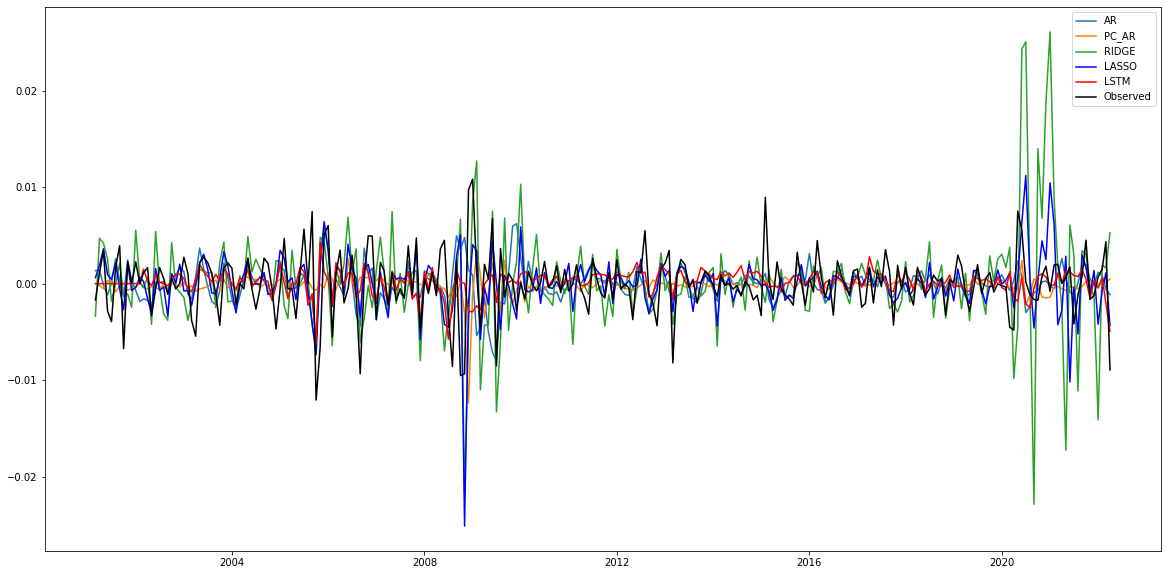

In [26]:
plt.figure(figsize= (20, 10))
plt.plot(df_final["AR"])
plt.plot(df_final["PC_AR"])
plt.plot(df_final["RIDGE"])
plt.plot(df_final["LASSO"], color = "blue")
#plt.plot(df_final["RF"])
#plt.plot(df_final["XGB"])
plt.plot(df_final["LSTM"], color = "red")
plt.plot(df_final["Observed"], color = "black")
#plt.legend(["AR", "PC_AR", "RIDGE", "LASSO", "RF", "XGB", "LSTM", "Observed"])
plt.legend(["AR", "PC_AR", "RIDGE", "LASSO", "LSTM", "Observed"])
plt.show()

In [27]:
table_1 = [["Auto Regressive Model (AR)", mse_ar, mae_ar, rmse_ar],
        ["Principal Component Auto Regressive Model (PCAR)", mse_pc_ar, mae_pc_ar, rmse_pc_ar], 
        ["Ridge Regression", mse_ridge, mae_ridge, rmse_ridge], 
        ["LASSO Regression", mse_lasso, mae_lasso, rmse_lasso],
         ["LSTM", mse_lstm, mae_lstm, rmse_lstm]]

head_1 = ["MSE", "MAE", "RMSE"]

print(tabulate(table_1, headers = head_1, tablefmt = "grid"))

+--------------------------------------------------+-------------+------------+------------+
|                                                  |         MSE |        MAE |       RMSE |
+==================================================+=============+============+============+
| Auto Regressive Model (AR)                       | 1.01521e-05 | 0.00219663 | 0.00318624 |
+--------------------------------------------------+-------------+------------+------------+
| Principal Component Auto Regressive Model (PCAR) | 1.14402e-05 | 0.00233139 | 0.00338233 |
+--------------------------------------------------+-------------+------------+------------+
| Ridge Regression                                 | 2.92602e-05 | 0.00352208 | 0.00540927 |
+--------------------------------------------------+-------------+------------+------------+
| LASSO Regression                                 | 1.12005e-05 | 0.00224838 | 0.00334671 |
+--------------------------------------------------+-------------+----

We can see from the Root Mean Square Error that the LSTM worked better in predicting inflation than the linear models. However, the difference is very small, and the computational cost of training an LSTM is much higher, for example, than estimating a LASSO regression. In addition, LASSO coefficients can be interpreted and it is possible to analyze the relationship between independent variables of interest and inflation. It is also worth mentioning that linear models have a worse performance in periods of crisis, that is, they have a worse predictive capacity in periods of high inflation volatility, this is notable for the greater errors in the periods of 2008 and 2020.

<h3> 2.B Comparation between Linear Models and Trees (Random Forest and Extreme Gradient Boosting). <h3>

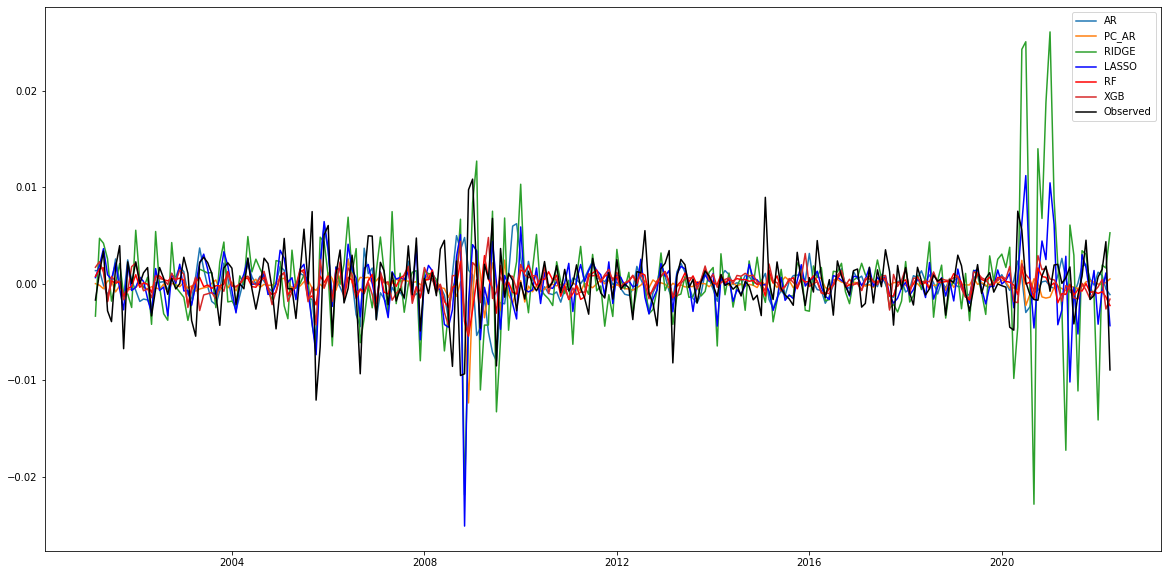

In [28]:
plt.figure(figsize= (20, 10))
plt.plot(df_final["AR"])
plt.plot(df_final["PC_AR"])
plt.plot(df_final["RIDGE"])
plt.plot(df_final["LASSO"], color = "blue")
plt.plot(df_final["RF"], color = "red")
plt.plot(df_final["XGB"])
#plt.plot(df_final["LSTM"], color = "red")
plt.plot(df_final["Observed"], color = "black")
#plt.legend(["AR", "PC_AR", "RIDGE", "LASSO", "RF", "XGB", "LSTM", "Observed"])
plt.legend(["AR", "PC_AR", "RIDGE", "LASSO", "RF", "XGB", "Observed"])
plt.show()

In [29]:
table_2 = [["Auto Regressive Model (AR)", mse_ar, mae_ar, rmse_ar],
        ["Principal Component Auto Regressive Model (PCAR)", mse_pc_ar, mae_pc_ar, rmse_pc_ar], 
        ["Ridge Regression", mse_ridge, mae_ridge, rmse_ridge], 
        ["LASSO Regression", mse_lasso, mae_lasso, rmse_lasso],
        ["Random Forest", mse_rf, mae_rf, rmse_rf],
        ["Extreme Gradient Boosting Tree", mse_xgb, mae_xgb, rmse_xgb]]

head_2 = ["MSE", "MAE", "RMSE"]

print(tabulate(table_2, headers = head_2, tablefmt = "grid"))

+--------------------------------------------------+-------------+------------+------------+
|                                                  |         MSE |        MAE |       RMSE |
+==================================================+=============+============+============+
| Auto Regressive Model (AR)                       | 1.01521e-05 | 0.00219663 | 0.00318624 |
+--------------------------------------------------+-------------+------------+------------+
| Principal Component Auto Regressive Model (PCAR) | 1.14402e-05 | 0.00233139 | 0.00338233 |
+--------------------------------------------------+-------------+------------+------------+
| Ridge Regression                                 | 2.92602e-05 | 0.00352208 | 0.00540927 |
+--------------------------------------------------+-------------+------------+------------+
| LASSO Regression                                 | 1.12005e-05 | 0.00224838 | 0.00334671 |
+--------------------------------------------------+-------------+----

Again, even though Random Forest's RMSE is smaller than all linear models, the difference is very small. Again, linear models behave much worse in crisis periods than trees. Would it be worth trading interpretability and lower computational cost for greater predictive capacity in times of crisis?

<h3> 2.D Comparation between Trees and LSTM neural network. <h3>

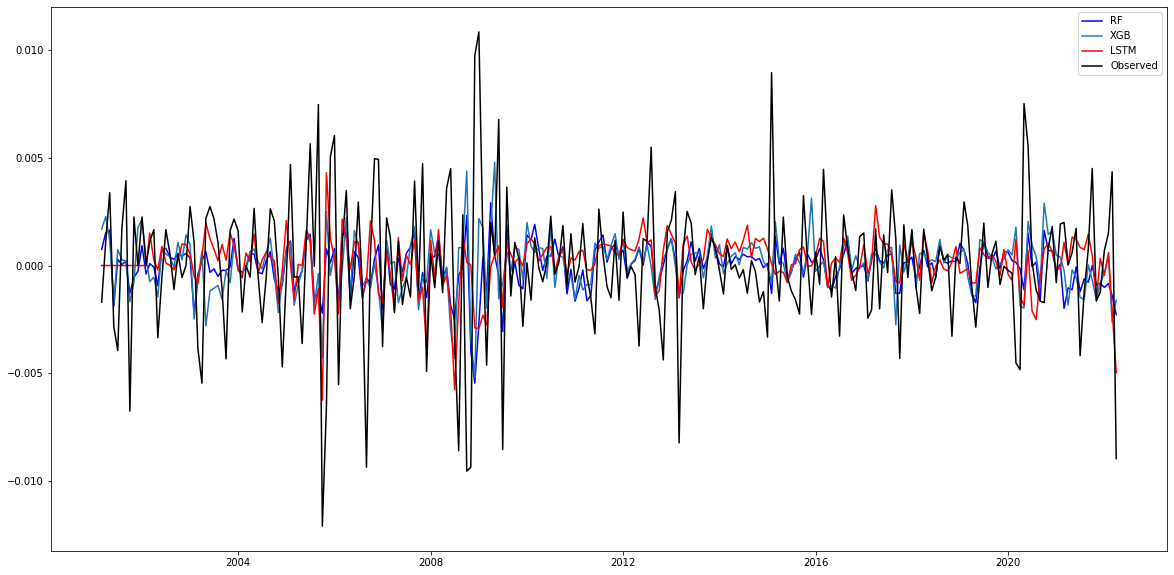

In [30]:
plt.figure(figsize= (20, 10))
#plt.plot(df_final["AR"])
#plt.plot(df_final["PC_AR"])
#plt.plot(df_final["RIDGE"])
#plt.plot(df_final["LASSO"], color = "blue")
plt.plot(df_final["RF"], color = "blue")
plt.plot(df_final["XGB"])
plt.plot(df_final["LSTM"], color = "red")
plt.plot(df_final["Observed"], color = "black")
#plt.legend(["AR", "PC_AR", "RIDGE", "LASSO", "RF", "XGB", "LSTM", "Observed"])
plt.legend(["RF", "XGB", "LSTM", "Observed"])
plt.show()

In [31]:
table_3 = [["Random Forest", mse_rf, mae_rf, rmse_rf],
        ["Extreme Gradient Boosting Tree", mse_xgb, mae_xgb, rmse_xgb],
         ["LSTM", mse_lstm, mae_lstm, rmse_lstm]]

head_3 = ["MSE", "MAE", "RMSE"]

print(tabulate(table_3, headers = head_3, tablefmt = "grid"))

+--------------------------------+-------------+------------+------------+
|                                |         MSE |        MAE |       RMSE |
+================================+=============+============+============+
| Random Forest                  | 9.33151e-06 | 0.00204534 | 0.00305475 |
+--------------------------------+-------------+------------+------------+
| Extreme Gradient Boosting Tree | 1.03325e-05 | 0.00222462 | 0.00321442 |
+--------------------------------+-------------+------------+------------+
| LSTM                           | 9.2053e-06  | 0.00205283 | 0.00303402 |
+--------------------------------+-------------+------------+------------+


Random Forest and LSTM performed very similarly in predicting US inflation.

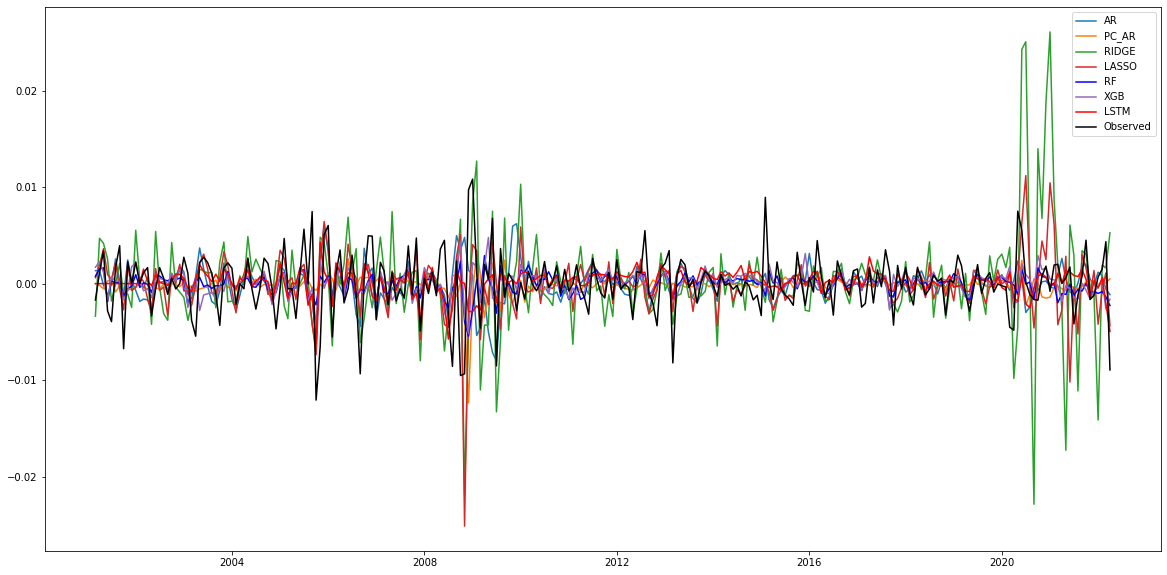

In [32]:
plt.figure(figsize= (20, 10))
plt.plot(df_final["AR"])
plt.plot(df_final["PC_AR"])
plt.plot(df_final["RIDGE"])
plt.plot(df_final["LASSO"])
plt.plot(df_final["RF"], color = "blue")
plt.plot(df_final["XGB"])
plt.plot(df_final["LSTM"], color = "red")
plt.plot(df_final["Observed"], color = "black")
plt.legend(["AR", "PC_AR", "RIDGE", "LASSO", "RF", "XGB", "LSTM", "Observed"])
plt.show()

In [33]:
table = [["Auto Regressive Model (AR)", mse_ar, mae_ar, rmse_ar],
        ["Principal Component Auto Regressive Model (PCAR)", mse_pc_ar, mae_pc_ar, rmse_pc_ar], 
        ["Ridge Regression", mse_ridge, mae_ridge, rmse_ridge], 
        ["LASSO Regression", mse_lasso, mae_lasso, rmse_lasso],
        ["Random Forest", mse_rf, mae_rf, rmse_rf],
        ["Extreme Gradient Boosting Tree", mse_xgb, mae_xgb, rmse_xgb],
         ["LSTM", mse_lstm, mae_lstm, rmse_lstm]]

head = ["MSE", "MAE", "RMSE"]

print(tabulate(table, headers = head, tablefmt = "grid"))

+--------------------------------------------------+-------------+------------+------------+
|                                                  |         MSE |        MAE |       RMSE |
+==================================================+=============+============+============+
| Auto Regressive Model (AR)                       | 1.01521e-05 | 0.00219663 | 0.00318624 |
+--------------------------------------------------+-------------+------------+------------+
| Principal Component Auto Regressive Model (PCAR) | 1.14402e-05 | 0.00233139 | 0.00338233 |
+--------------------------------------------------+-------------+------------+------------+
| Ridge Regression                                 | 2.92602e-05 | 0.00352208 | 0.00540927 |
+--------------------------------------------------+-------------+------------+------------+
| LASSO Regression                                 | 1.12005e-05 | 0.00224838 | 0.00334671 |
+--------------------------------------------------+-------------+----

The best model estimated in terms of the lowest RMSE was the LSTM, even though the difference to the others was very small. The computational expense and loss of interpretability in relation to linear models may not make the use of LSTM feasible. However, LSTM, Random Forest and Extreme Gradient Boosting Trees perform better in times of crisis. It may be interesting to observe the relationship between the errors of the models, and if there is no great correlation, it may be feasible to implement an Ensemble (Stacking or Average method) and compare with the estimated single models.